# Semantic Embedding and Distances: Assessing Gender Consistency in Directional and Magnitudinal Embedding Spaces

## Introduction

In the rapidly advancing field of Natural Language Processing (NLP), semantic embeddings have emerged as a cornerstone for a multitude of applications, enabling machines to grasp complex human language nuances. These embeddings, which translate words into high-dimensional vectors, are pivotal for assessing semantic similarity—how closely the meanings of words relate to each other within a given linguistic context. A particularly intriguing area of study within semantic embeddings is the exploration of how gender dimensions are represented and whether there is an inherent bias in these representations.

This research delves into the gendered landscape of semantic embeddings, focusing on the hypothesis that the gender opposition of the same concept is reflected in a consistent pattern within the vector space. By comparing word pairs that signify the same concept but differ in gender - such as "waitress" vs. "waiter" or "actor" vs. "actress" — this study examines both the directional and magnitudinal similarities in their respective word vectors. The consistency of these dimensions could unveil systematic patterns in how gendered language is encoded within word embeddings, potentially shedding light on latent biases. [Previous studies](https://arxiv.org/pdf/2206.03390.pdf#:~:text=Specifically%2C%20of%20the%20top%201%2C000,55%25%20are%20associated%20with%20men.) have explored aspects of gender bias in semantic embeddings, providing a foundation upon which this research builds. The goal is to offer a deeper understanding of gender representation in semantic spaces, contributing to the ongoing conversation on fairness and equality in machine learning algorithms.

## Research Question

The investigation at the heart of this study is encapsulated in the research question: How consistent are the directional and magnitudinal differences between word embeddings for gender-specific pairs across various semantic concepts? This question seeks to quantitatively unravel the gender dimensions encoded within word embeddings, focusing specifically on whether the embedded vectors of gender-opposite words representing the same concept exhibit a standard distance and orientation in the semantic vector space.

To elucidate this further, the research examines the extent to which the semantic similarity (or rather, dissimilarity), as captured by cosine and Euclidean distances, between male and female word pairs such as "actor" and "actress" or "king" and "queen", remains constant across different concepts. The analysis of this consistency could provide pivotal insights into the structural biases of word embeddings and their implications for gender representation in automated language processing. The exploration is grounded in the hypothesis that the gender difference of a concept is represented by roughly equivalent distances in the embedding space, implying a uniformity in how NLP models process gendered language. 

## Data

The study utilizes a [licensed dataset from WordNet](https://github.com/ecmonsen/gendered_words/tree/master), ensuring the credibility and reliability of the linguistic data underpinning the research. This dataset encompasses a total of 6,923 words, each rigorously annotated with gender designations—'f' for female, 'm' for male, and 'n' for gender-neutral—reflecting the natural gender of the person or type of person to which the word refers. In addition to the gender labels, the dataset includes a 'gender_map' column that provides connections to words of other genders, offering deeper insight into gender-based linguistic relationships. Although 'wordnet_senseno' is included in the dataset, providing a means to reference WordNet for additional lexical information, it will not be used in this analysis. The focus will remain squarely on the 'word' and 'gender' columns, with the intent to convert the JSON file into a tabular format using pandas DataFrames, allowing for a nuanced examination of gender representation across the dataset.

## Data Preperation

Importing necessary libraries and loading the dataset into a pandas DataFrame for further analysis.

`pandas` and `numpy` are essential for data manipulation and analysis, while `matplotlib` and `seaborn` are used for data visualization. The dataset is loaded into a pandas DataFrame, providing a structured format for exploring the gendered words and their corresponding

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Specify the file path
file_path = "./gendered_words.json"

# Read the JSON file into a DataFrame
df = pd.read_json(file_path)

# Display the DataFrame
df


,word,wordnet_senseno,gender,gender_map
0,abandoned_person,abandoned_person.n.01,n,NaN
1,abator,abator.n.01,n,NaN
2,abbe,abbe.n.01,n,NaN
3,abbess,abbess.n.01,f,"{'m': [{'parts_of_speech': '*', 'word': 'abbot..."
4,abbot,abbot.n.01,m,NaN
...,...,...,...,...
6918,zoo_keeper,zoo_keeper.n.01,n,NaN
6919,zoologist,zoologist.n.01,n,NaN
6920,zoroastrian,zoroastrian.n.01,n,NaN
6921,zulu,zulu.n.01,n,NaN


Further extract columns from the gender_map column: alt_word and alt_gender. This essentially matches words with their opposite gender counterparts, providing a foundation for the subsequent analysis

In [16]:
df = df.dropna(subset=['gender_map'])
def extract_info(row):
    for gender, details in row.items():
        return pd.Series({
            'alt_gender': gender,
            'alt_word': details[0]['word']
        })
expanded_data = df['gender_map'].apply(extract_info)
df = df.join(expanded_data)

df.drop_duplicates(subset='word', inplace=True) # dropping duplicates
df.reset_index(drop=True, inplace=True)
df.drop(columns=['gender_map'], inplace=True)

df

,word,wordnet_senseno,gender,alt_gender,alt_word
0,abbess,abbess.n.01,f,m,abbot
1,able_seaman,able_seaman.n.01,m,f,able_seawoman
2,actress,actress.n.01,f,m,actor
3,adulteress,adulteress.n.01,f,m,adulterer
4,adventuress,adventuress.n.01,f,m,adventurer
...,...,...,...,...,...
499,yachtsman,yachtsman.n.01,m,f,yachtswoman
500,yardman,yardman.n.02,m,f,yardwoman
501,yellow_man,yellow_man.n.01,m,f,yellow_woman
502,yellow_woman,yellow_woman.n.01,f,m,yellow_man


Further reducing duplicates in the dataset by removing rows where the word is the same as the alt_word. This step ensures that the subsequent nlp word vectorization, which is a computationally intensive process, is not redundant.

In [17]:
df = df[~df['word'].isin(df['alt_word'])]
df

,word,wordnet_senseno,gender,alt_gender,alt_word
0,abbess,abbess.n.01,f,m,abbot
1,able_seaman,able_seaman.n.01,m,f,able_seawoman
2,actress,actress.n.01,f,m,actor
3,adulteress,adulteress.n.01,f,m,adulterer
4,adventuress,adventuress.n.01,f,m,adventurer
...,...,...,...,...,...
497,working_girl,working_girl.n.01,f,m,working_boy
498,workman,workman.n.01,m,f,workwoman
499,yachtsman,yachtsman.n.01,m,f,yachtswoman
500,yardman,yardman.n.02,m,f,yardwoman


Initializing the spaCy model for word vectorization, which will be used to generate word embeddings for the words in the dataset. Here, we will be using the large English model 'en_core_web_lg' to enable word vectorization.

In [18]:
import spacy
import spacy.cli

# Ensure that model isn't installed repeatedly
try:
    # Try to load the model to see if it's already installed
    nlp = spacy.load("en_core_web_lg")
    print("Model is successfully loaded.")
except OSError:
    # If the model is not installed, download it
    print("Model not found. Downloading now...")
    spacy.cli.download("en_core_web_lg")
    print("Model is successfully loaded.")


Model is successfully loaded.


apply the spaCy model to the 'word' and 'alt_word' column in the DataFrame, generating word embeddings.

In [19]:
df = df.copy()
df['word_vector'] = df['word'].apply(lambda x: nlp(x).vector)
df['alt_word_vector'] = df['alt_word'].apply(lambda x: nlp(x).vector)
df

,word,wordnet_senseno,gender,alt_gender,alt_word,word_vector,alt_word_vector
0,abbess,abbess.n.01,f,m,abbot,"[-0.055308, -4.1129, 0.13099, -0.66051, -0.074...","[-2.4365, -5.7415, -0.18164, 0.86196, 0.56676,..."
1,able_seaman,able_seaman.n.01,m,f,able_seawoman,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,actress,actress.n.01,f,m,actor,"[-0.19423, 1.952, -1.9048, -4.79, -0.63103, 0....","[-2.2196, 0.825, -1.2274, -3.7514, -0.51313, 1..."
3,adulteress,adulteress.n.01,f,m,adulterer,"[0.15472, -0.64138, -1.5163, -1.8773, 0.92957,...","[-0.8278, -1.0626, -0.70223, -1.6146, 1.5188, ..."
4,adventuress,adventuress.n.01,f,m,adventurer,"[-0.70933, 0.13014, 0.046859, -3.7926, -0.8595...","[-0.05648, -0.19939, 1.4233, -4.7611, -1.5092,..."
...,...,...,...,...,...,...,...
497,working_girl,working_girl.n.01,f,m,working_boy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
498,workman,workman.n.01,m,f,workwoman,"[-2.3501, -1.2634, -1.299, -1.1481, 1.0886, -2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
499,yachtsman,yachtsman.n.01,m,f,yachtswoman,"[-1.479, -0.47629, 1.3346, -1.8885, -0.28168, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
500,yardman,yardman.n.02,m,f,yardwoman,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


The resulting dataframe above shows that some of the words returned zero-vectors. This is likely due to the words not being present in the spaCy vocabulary. To address this, will will remove these zero-vectors from the dataset.

In [20]:
df = df[df['word_vector'].apply(lambda x: sum(x) != 0)]
df = df[df['alt_word_vector'].apply(lambda x: sum(x) != 0)]

Reorganizing the datframe columns for ease of analysis

In [21]:
column_order = ['word', 'gender', 'word_vector', 'alt_word', 'alt_gender', 'alt_word_vector']
df = df.reindex(columns=column_order)
df.reset_index(drop=True, inplace=True)
df

,word,gender,word_vector,alt_word,alt_gender,alt_word_vector
0,abbess,f,"[-0.055308, -4.1129, 0.13099, -0.66051, -0.074...",abbot,m,"[-2.4365, -5.7415, -0.18164, 0.86196, 0.56676,..."
1,actress,f,"[-0.19423, 1.952, -1.9048, -4.79, -0.63103, 0....",actor,m,"[-2.2196, 0.825, -1.2274, -3.7514, -0.51313, 1..."
2,adulteress,f,"[0.15472, -0.64138, -1.5163, -1.8773, 0.92957,...",adulterer,m,"[-0.8278, -1.0626, -0.70223, -1.6146, 1.5188, ..."
3,adventuress,f,"[-0.70933, 0.13014, 0.046859, -3.7926, -0.8595...",adventurer,m,"[-0.05648, -0.19939, 1.4233, -4.7611, -1.5092,..."
4,alderman,m,"[-4.3969, -0.82028, -2.786, -0.4409, -0.96385,...",alderwoman,f,"[-0.84285, 0.26816, -1.1955, -0.3671, -0.48003..."
...,...,...,...,...,...,...
102,usherette,f,"[-0.72282, 0.85698, 1.6112, 1.114, 1.4241, -0....",usher,m,"[0.81333, 2.245, 2.5363, 4.8562, 0.73824, -2.1..."
103,villainess,f,"[-0.41305, 0.34085, -1.6585, -1.3554, 0.75527,...",villain,m,"[-3.1279, 1.2109, -1.2268, -3.6413, 0.48546, 2..."
104,viscountess,f,"[-0.78314, -2.4582, -2.5171, -0.62797, -0.2330...",viscount,m,"[-1.6131, -3.9941, -4.6799, 1.0634, 1.7659, -0..."
105,waitress,f,"[1.6695, -0.29016, -0.80709, 0.15619, -1.0238,...",waiter,m,"[0.74452, 0.30464, 0.936, 1.1466, -1.5493, -1...."


Check if every word has a corresponding alt_word with the opposite gender. 

In [22]:
check = (df['gender'] == 'f') & (df['alt_gender'] == 'm') | (df['gender'] == 'm') & (df['alt_gender'] == 'f')
check.all()

True

Calculating the cosine and Euclidean distances between the word embeddings of the words

In [23]:
from scipy.spatial.distance import cosine, euclidean

# Calculate cosine distance for each row and create a new column with the results
df['cosine_distance'] = df.apply(lambda row: cosine(row['word_vector'], row['alt_word_vector']), axis=1)

# Calculate Euclidean distance for each row and create a new column with the results
df['euclidean_distance'] = df.apply(lambda row: euclidean(row['word_vector'], row['alt_word_vector']), axis=1)
df


,word,gender,word_vector,alt_word,alt_gender,alt_word_vector,cosine_distance,euclidean_distance
0,abbess,f,"[-0.055308, -4.1129, 0.13099, -0.66051, -0.074...",abbot,m,"[-2.4365, -5.7415, -0.18164, 0.86196, 0.56676,...",0.177864,25.196053
1,actress,f,"[-0.19423, 1.952, -1.9048, -4.79, -0.63103, 0....",actor,m,"[-2.2196, 0.825, -1.2274, -3.7514, -0.51313, 1...",0.190069,32.269463
2,adulteress,f,"[0.15472, -0.64138, -1.5163, -1.8773, 0.92957,...",adulterer,m,"[-0.8278, -1.0626, -0.70223, -1.6146, 1.5188, ...",0.168183,14.652782
3,adventuress,f,"[-0.70933, 0.13014, 0.046859, -3.7926, -0.8595...",adventurer,m,"[-0.05648, -0.19939, 1.4233, -4.7611, -1.5092,...",0.176657,17.257338
4,alderman,m,"[-4.3969, -0.82028, -2.786, -0.4409, -0.96385,...",alderwoman,f,"[-0.84285, 0.26816, -1.1955, -0.3671, -0.48003...",0.426608,24.997730
...,...,...,...,...,...,...,...,...
102,usherette,f,"[-0.72282, 0.85698, 1.6112, 1.114, 1.4241, -0....",usher,m,"[0.81333, 2.245, 2.5363, 4.8562, 0.73824, -2.1...",0.357998,25.234131
103,villainess,f,"[-0.41305, 0.34085, -1.6585, -1.3554, 0.75527,...",villain,m,"[-3.1279, 1.2109, -1.2268, -3.6413, 0.48546, 2...",0.319328,26.309505
104,viscountess,f,"[-0.78314, -2.4582, -2.5171, -0.62797, -0.2330...",viscount,m,"[-1.6131, -3.9941, -4.6799, 1.0634, 1.7659, -0...",0.193501,19.761242
105,waitress,f,"[1.6695, -0.29016, -0.80709, 0.15619, -1.0238,...",waiter,m,"[0.74452, 0.30464, 0.936, 1.1466, -1.5493, -1....",0.216654,20.387665


With that, the dataframe is now ready for analysis, with the words fully paired with their gender opposites and the cosine and Euclidean distances calculated for each pair. This cleanup process left us with 107 pairs of gender-opposite word pairs to work with for our analysis. 

## Statistical Analysis

First, we will examine the distribution of cosine distances

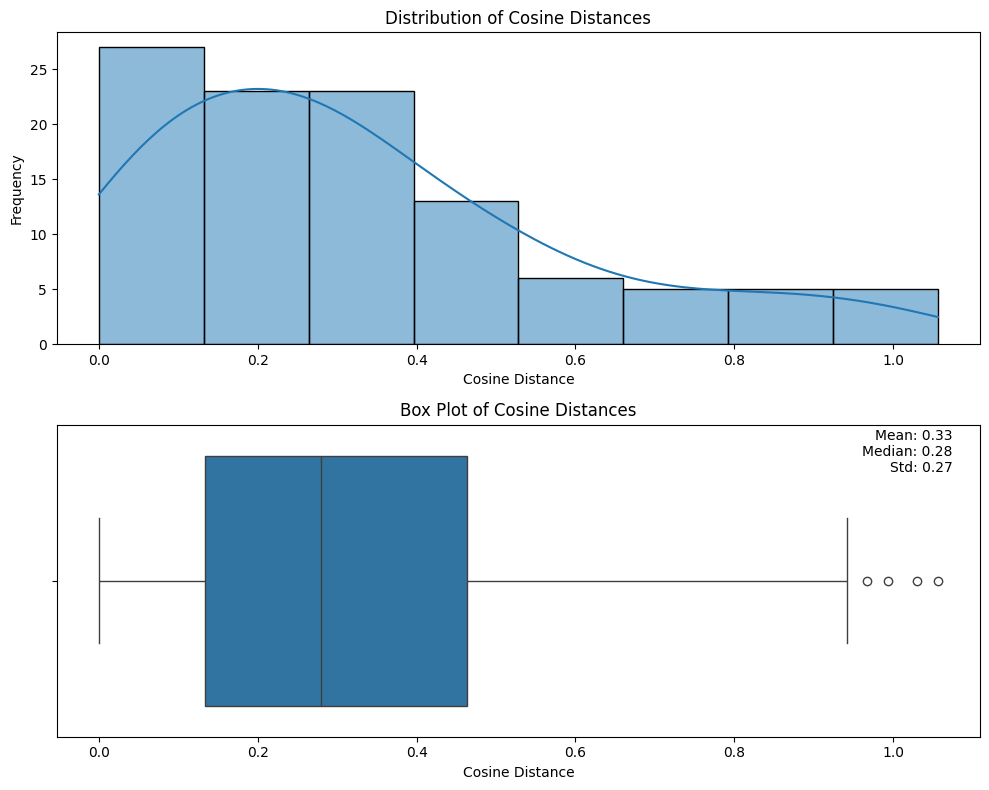

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Subplot 1: Histogram
sns.histplot(df['cosine_distance'], kde=True, ax=ax1)
ax1.set_title('Distribution of Cosine Distances')
ax1.set_xlabel('Cosine Distance')
ax1.set_ylabel('Frequency')

# Subplot 2: Box plot
sns.boxplot(x=df['cosine_distance'], ax=ax2)
ax2.set_title('Box Plot of Cosine Distances')
ax2.set_xlabel('Cosine Distance')

# Calculate mean, median, and std
mean = df['cosine_distance'].mean()
median = df['cosine_distance'].median()
std = df['cosine_distance'].std()

# Position the annotations on the plot. Adjust the y-coordinates as needed.
ax2.text(0.97, 0.95, f'Mean: {mean:.2f}', transform=ax2.transAxes, ha='right')
ax2.text(0.97, 0.90, f'Median: {median:.2f}', transform=ax2.transAxes, ha='right')
ax2.text(0.97, 0.85, f'Std: {std:.2f}', transform=ax2.transAxes, ha='right')

plt.tight_layout()
plt.show()

Similarly, we will examine the distribution of distances

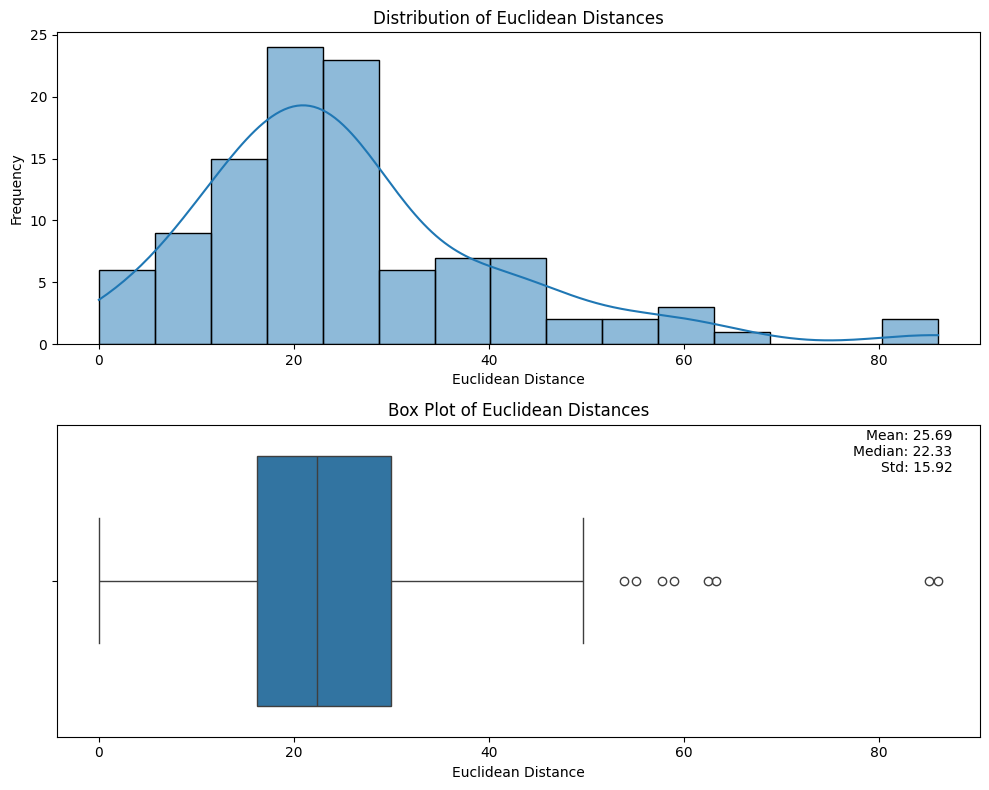

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Subplot 1: Histogram
sns.histplot(df['euclidean_distance'], kde=True, ax=ax1)
ax1.set_title('Distribution of Euclidean Distances')
ax1.set_xlabel('Euclidean Distance')
ax1.set_ylabel('Frequency')

# Subplot 2: Box plot
sns.boxplot(x=df['euclidean_distance'], ax=ax2)
ax2.set_title('Box Plot of Euclidean Distances')
ax2.set_xlabel('Euclidean Distance')

# Calculate mean, median, and std
mean = df['euclidean_distance'].mean()
median = df['euclidean_distance'].median()
std = df['euclidean_distance'].std()

# Position the annotations on the plot. Adjust the y-coordinates as needed.
ax2.text(0.97, 0.95, f'Mean: {mean:.2f}', transform=ax2.transAxes, ha='right')
ax2.text(0.97, 0.90, f'Median: {median:.2f}', transform=ax2.transAxes, ha='right')
ax2.text(0.97, 0.85, f'Std: {std:.2f}', transform=ax2.transAxes, ha='right')

plt.tight_layout()
plt.show()


Normality Test of the Distribution of the Euclidean Distances

In [26]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test for euclidean_distance
statistic_euclidean, p_value_euclidean = shapiro(df['euclidean_distance'])

# Print the test statistic and p-value for euclidean_distance
print("Shapiro-Wilk Test Statistic(W) for Euclidean Distance:", statistic_euclidean)
print("p-value for Euclidean Distance:", p_value_euclidean)

# Perform Shapiro-Wilk test for cosine_distance
statistic_cosine, p_value_cosine = shapiro(df['cosine_distance'])

# Print the test statistic and p-value for cosine_distance
print("Shapiro-Wilk Test Statistic(W) for Cosine Distance:", statistic_cosine)
print("p-value for Cosine Distance:", p_value_cosine)

Shapiro-Wilk Test Statistic(W) for Euclidean Distance: 0.9015517780489521
p-value for Euclidean Distance: 8.277290835575509e-07
Shapiro-Wilk Test Statistic(W) for Cosine Distance: 0.9103010479122974
p-value for Cosine Distance: 2.2779791109505928e-06


Here, the Shapiro-Wilk test was utilized to assess the normality of the distribution of Cosine distances and Euclidean distance between word pairs representing different genders across various concepts. The Shapiro-Wilk test produced statistics of roughly 0.9 and a p-value less than 0.05 for both distance metrics, suggesting a  deviation from a normal distribution. And the significantly low p-value, far below the typical alpha threshold of 0.05, provides strong evidence to reject the null hypothesis of normal distribution. This result indicates that both distances in the dataset **do not follow a normal distribution**, highlighting the need for **non-parametric** statistical methods in further analyses or alternative methods to test our hypothesis. Identifying the non-normal distribution of the data is critical as it guides the selection of appropriate statistical techniques that do not assume normality, ensuring the accuracy and integrity of the analysis on gender representations in word embeddings.

After careful consideration, a Booststrap resampling method was chosen to test the hypothesis as it will provide useful insights to the intricate confidence intervals of the mean cosine and Euclidean distances. This can help us understand whether there is a consistent pattern in directional and magnitudinal differences between word embeddings. A smaller confidence interval would indicate a higher level of consistency in the distances between gender-opposite word pairs of the same concept, while a larger interval would suggest otherwise. 

In [27]:
# Define the number of bootstrap samples to draw
n_bootstraps = 10000

# Function to draw bootstrap samples and calculate the mean of the distances
def bootstrap_mean(sample, n_bootstraps):
    boot_means = []
    for _ in range(n_bootstraps):
        # Sample with replacement from the given sample
        boot_sample = np.random.choice(sample, size=len(sample), replace=True)
        # Calculate the mean of this bootstrap sample
        boot_means.append(np.mean(boot_sample))
    return boot_means

# Bootstrap for cosine distance
cosine_means = bootstrap_mean(df['cosine_distance'], n_bootstraps)

# Bootstrap for Euclidean distance
euclidean_means = bootstrap_mean(df['euclidean_distance'], n_bootstraps)

# Calculate the 95% confidence intervals for each distribution of bootstrap means
cosine_conf_int = np.percentile(cosine_means, [2.5, 97.5])
euclidean_conf_int = np.percentile(euclidean_means, [2.5, 97.5])

# Output the results
print("95% confidence interval for the mean cosine distance:", cosine_conf_int)
print("95% confidence interval for the mean Euclidean distance:", euclidean_conf_int)


95% confidence interval for the mean cosine distance: [0.28280635 0.38354084]
95% confidence interval for the mean Euclidean distance: [22.80622134 28.7457731 ]


Here, bootstrap methodology, which does not assume underlying data distribution, was employed to generate 95% confidence intervals for both cosine and Euclidean distances of word pairs representing the same concepts with different genders. For cosine distance, which measures the directionality of word vectors in the semantic space, the confidence interval ranges from approximately 0.283 to 0.384. This means that for two words representing the same concept, the angular (directional) differences roughly lies between 0.283 to 0.384. Considering cosine distance can range from 0-2, this 95% CI can be viewed as moderately narrow. This narrow interval suggests a considerable level of consistency in the directional relationships between gendered word pairs, indicating that the angle between the vectors of male and female word pairs is relatively uniform across different concepts. Such a result supports the hypothesis that the linguistic representation of gender in word embeddings exhibits a directional consistency. 

On the other hand, the Euclidean distance, capturing the magnitude of difference in the high-dimensional space of word embeddings, exhibits a 95% confidence interval ranging from 22.813 to 28.766. Note that euclidean distance captures the magnitude difference instead of angular difference between vectors, the scale of this distance metric is much larger (0 to infinite). This interval still conveys a considerable degree of consistency in the magnitudes of differences between the embeddings of gendered word pairs. This is indicative of a bounded variability in the representation of gender across different concepts. 

These results collectively support the hypothesis that there is a stable pattern in how genders are represented in word embeddings across various concepts, both directionally and in terms of magnitude. 

## Discussion

The application of bootstrap subsampling has provided a window into the gender representation within semantic embeddings, yielding intervals that suggest a degree of consistency in both directional and magnitudinal aspects. However, determining what constitutes a "small enough" interval remains arbitrary and presents a limitation to the conclusiveness of the results. A more definitive analysis could benefit from comparing the confidence intervals of distances for words that exhibit semantic differences beyond gender, as well as for words unrelated to gender, to establish a baseline or control group for what "consistency" might entail in this context.

The data preparation stage, while meticulous, resulted in a significant reduction of the dataset from its original size. Although starting with over 6,000 labeled words, the criteria for inclusion narrowed the focus to a smaller subset of word pairs, which may limit the generalizability of the findings. Future studies could leverage a larger dataset, potentially enhanced by leveraging the capabilities of Large Language Models (LLMs) and transformer models. These advanced tools could not only compensate for the limited data but also provide a means to synthesize additional data points, thereby enriching the dataset and possibly uncovering subtler patterns of gender representation. This direction would not only bolster the robustness of the findings but also align the study with the cutting-edge methodologies currently shaping the field of NLP.

## Conclusion

Through the application of bootstrap methodology, we have gained insights into the consistency of gender-specific word pairs across various concepts, with findings suggesting moderate uniformity in directional relationships and a bounded variability in magnitudes. Although the bootstrap approach provided valuable information, it also highlighted the challenges of defining clear thresholds for "small enough" intervals within the context of semantic similarity metrics.

The research encountered limitations due to dataset size constraints after a rigorous data preparation process. Recognizing this, future work could expand the dataset, potentially integrating advanced computational models such as LLMs and transformers to augment data robustness. This would allow for a broader and more detailed analysis, possibly revealing deeper insights into the underlying structures of gender representation in semantic spaces. The pursuit of this goal would contribute significantly to the ongoing discourse on algorithmic fairness and the social implications of automated language processing.